In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
df = pd.read_csv('hospital_readmissions.csv')

df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


Column names after cleaning: Index(['age', 'time_in_hospital', 'n_lab_procedures', 'n_procedures',
       'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test',
       'a1ctest', 'change', 'diabetes_med', 'readmitted'],
      dtype='object')
Found medical columns: ['medical_specialty']
Found diagnostic columns: ['diag_1', 'diag_2', 'diag_3']
Missing values before handling:
age                                            0
time_in_hospital                               0
n_lab_procedures                               0
n_procedures                                   0
n_medications                                  0
n_outpatient                                   0
n_inpatient                                    0
n_emergency                                    0
glucose_test                                1375
a1ctest                                     4062
change                                         0
dia

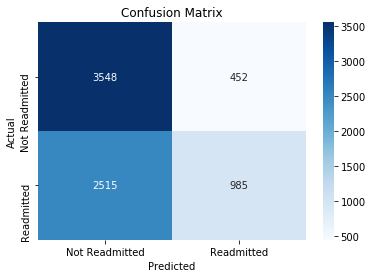

In [8]:
# Step 1: Clean column names (strip spaces, convert to lowercase)
df.columns = df.columns.str.strip().str.lower()
print("Column names after cleaning:", df.columns)

# Step 2: Handle binary columns ('yes'/'no' -> 1/0)
binary_columns = ['glucose_test', 'a1ctest', 'change', 'diabetes_med', 'readmitted']
for col in binary_columns:
    if col in df.columns:
        df[col] = df[col].map({'yes': 1, 'no': 0})
    else:
        print(f"Warning: {col} not found in the dataset")

# Step 3: Convert age ranges to numeric values
if 'age' in df.columns:
    age_mapping = {
        '[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3,
        '[40-50)': 4, '[50-60)': 5, '[60-70)': 6, '[70-80)': 7,
        '[80-90)': 8, '[90-100)': 9
    }
    df['age'] = df['age'].map(age_mapping)
else:
    print("Warning: 'age' column not found in the dataset")

# Step 4: Dynamically find medical and diagnostic columns
medical_cols = [col for col in df.columns if 'medical' in col.lower()]
diag_cols = [col for col in df.columns if 'diag' in col.lower()]

print(f"Found medical columns: {medical_cols}")
print(f"Found diagnostic columns: {diag_cols}")

# Step 5: One-hot encode the found categorical columns (only if they exist)
if len(medical_cols) > 0 or len(diag_cols) > 0:
    df = pd.get_dummies(df, columns=medical_cols + diag_cols, drop_first=True)
else:
    print("Warning: No medical or diagnostic columns found for one-hot encoding")

# Step 6: Check for missing values before imputation
print("Missing values before handling:")
print(df.isnull().sum())

# Step 7: Handle missing values with median imputation
imputer = SimpleImputer(strategy='median')
X = df.drop('readmitted', axis=1)  # Features
y = df['readmitted']               # Target (1 for 'yes', 0 for 'no')

# Check the shape of X and y before imputation
print(f"Shape of X before imputation: {X.shape}")
print(f"Shape of y before imputation: {y.shape}")

# Impute missing values
X = imputer.fit_transform(X)

# Check the shape of X after imputation
print(f"Shape of X after imputation: {X.shape}")

# Step 8: Ensure X and y have valid samples
if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("No samples available after preprocessing, check data transformations.")

# Step 9: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print shapes of training and test sets
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Step 10: Train the Support Vector Machine model (SVM)
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)  # Fit the model on the training data

# Step 11: Generate predictions on the test data
y_pred = svm_clf.predict(X_test)

# Step 12: Evaluate the model

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Readmitted', 'Readmitted'], yticklabels=['Not Readmitted', 'Readmitted'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
# Step 1: Re-train SVM with probability=True
svm_clf_proba = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf_proba.fit(X_train, y_train)

# Step 2: Get predicted probabilities for the positive class (class 1)
y_proba = svm_clf_proba.predict_proba(X_test)[:, 1]  # Only take the probabilities for class 1

# Step 3: Compute the ROC curve and the AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Step 4: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Step 5: Display the AUC score
print(f"AUC Score: {roc_auc:.2f}")
